* In this notebook we are trying to build a model that has the ability to classify cats and dogs. 
* The input data we will use is from a dataset provided by kaggle.
* This dataset consists of 25,000 images of cats and dogs.
* The dataset we will use is saved for us in '/kaggle/input/dogs-vs-cats'.
* The following command is to show us the format of the data.

In [1]:
import os
for file in os.listdir('/kaggle/input/dogs-vs-cats'):
    print(file)

test1.zip
train.zip
sampleSubmission.csv


**As shown above, the data is stored in two zip files named test1.zip and train.zip. So in order to deal with the data, we first have to extract these files.**

In [2]:
from zipfile import ZipFile as zf
train_zip = zf('/kaggle/input/dogs-vs-cats/train.zip', 'r')
train_zip.extractall()
train_zip.close()
test_zip = zf('/kaggle/input/dogs-vs-cats/test1.zip', 'r')
test_zip.extractall()
test_zip.close()

Now we have two main directories containing the dataset, a directory for the training set and another one for the test set. Both directories are in the working directory "./". Let's see how big is the dataset.

In [3]:
print('there exist ' + str(len(os.listdir('./train'))) + ' training examples')
print('there exist ' + str(len(os.listdir('./test1'))) + ' test examples')
print(os.listdir('./train')[0:10]) # print the first ten file names in the training set
print(os.listdir('./test1')[0:10]) # print the first ten file names in the training set

there exist 25000 training examples
there exist 12500 test examples
['dog.5731.jpg', 'cat.9891.jpg', 'cat.4866.jpg', 'dog.5806.jpg', 'dog.7041.jpg', 'cat.5759.jpg', 'dog.1443.jpg', 'dog.7823.jpg', 'dog.9624.jpg', 'dog.3316.jpg']
['10706.jpg', '9403.jpg', '10585.jpg', '7434.jpg', '8928.jpg', '2961.jpg', '2565.jpg', '6760.jpg', '7255.jpg', '9799.jpg']


Now that we have 25,000 training examples, we will split them into training set and validation set. We will not deal with the 12500 testing examoles now.

In [4]:
os.mkdir('./train1')
os.mkdir('./train1/cats')
os.mkdir('./train1/dogs')

In [5]:
import shutil

for file_name in os.listdir('./train'):
    if file_name.split('.')[0] == 'cat':
        shutil.copy(os.path.join('./train/', file_name) , os.path.join('./train1/cats', file_name))
    elif file_name.split('.')[0] == 'dog':
        shutil.copy(os.path.join('./train/', file_name) , os.path.join('./train1/dogs', file_name))

In [6]:
print(len(os.listdir('./train1/cats')))
print(len(os.listdir('./train1/dogs')))

12500
12500


Now we want to split the data into training and validation

In [7]:
os.mkdir('./training_set')
os.mkdir('./training_set/cats')
os.mkdir('./training_set/dogs')
os.mkdir('./val_set')
os.mkdir('./val_set/cats')
os.mkdir('./val_set/dogs')

In [8]:
import random
traincats = os.listdir('./train1/cats')
random.shuffle(traincats)
traindogs = os.listdir('./train1/dogs')
random.shuffle(traindogs)
for file_name in traincats[:10000]:
    shutil.copy(os.path.join('./train1/cats', file_name) , os.path.join('./training_set/cats', file_name))
for file_name in traincats[10000:]:
    shutil.copy(os.path.join('./train1/cats', file_name) , os.path.join('./val_set/cats', file_name))
for file_name in traindogs[:10000]:
    shutil.copy(os.path.join('./train1/dogs', file_name) , os.path.join('./training_set/dogs', file_name))
for file_name in traindogs[10000:]:
    shutil.copy(os.path.join('./train1/dogs', file_name) , os.path.join('./val_set/dogs', file_name))

In [9]:
print(len(os.listdir('./training_set/cats/')))
print(len(os.listdir('./training_set/dogs/')))
print(len(os.listdir('./val_set/cats/')))
print(len(os.listdir('./val_set/dogs/')))

10000
10000
2500
2500


Now let's define our model.

In [10]:
import tensorflow as tf
import tensorflow.keras.layers as tfl

model = tf.keras.Sequential([
    tfl.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(128, (3,3), activation='relu'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(256, (3,3), activation='relu'),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D(2,2),
    tfl.Flatten(),
    tfl.Dense(512, activation='relu'),
    tfl.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       2

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

Now, we are ready to train our Model. Except first we need to introduce our labeled data to our model. For this we will use the ImageDataGenerator.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )
train_generator = train_datagen.flow_from_directory(
    './training_set',
    target_size = (150,150),
    batch_size = 8,
    class_mode = 'binary'
)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    './val_set/',
    target_size = (150,150),
    batch_size = 8,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Now we are ready to train our Model

In [15]:
history = model.fit_generator(train_generator, epochs=100, validation_data=val_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
2500/2500 [==============================] - 189s 73ms/step - loss: 1.9672 - binary_accuracy: 0.5540 - val_loss: 0.6737 - val_binary_accuracy: 0.6154
Epoch 2/100
2500/2500 [==============================] - 183s 73ms/step - loss: 0.6596 - binary_accuracy: 0.6133 - val_loss: 0.6697 - val_binary_accuracy: 0.5550
Epoch 3/100
2500/2500 [==============================] - 184s 74ms/step - loss: 0.6439 - binary_accuracy: 0.6319 - val_loss: 0.6199 - val_binary_accuracy: 0.6300
Epoch 4/100
2500/2500 [==============================] - 190s 76ms/step - loss: 0.6189 - binary_accuracy: 0.6596 - val_loss: 0.5309 - val_binary_accuracy: 0.7454
Epoch 5/100
2500/2500 [==============================] - 192s 77ms/step - loss: 0.5650 - binary_accuracy: 0.7105 - val_loss: 0.6674 - val_binary_accuracy: 0.7184
Epoch 6/100
2500/2500 [==============================] - 189s 76ms/step - loss: 0.5182 - binary_accuracy: 0.7486 - val_loss: 0.6981 - val_binary_accuracy: 0.6560
Epoch 7/100
2500/2500 [=====

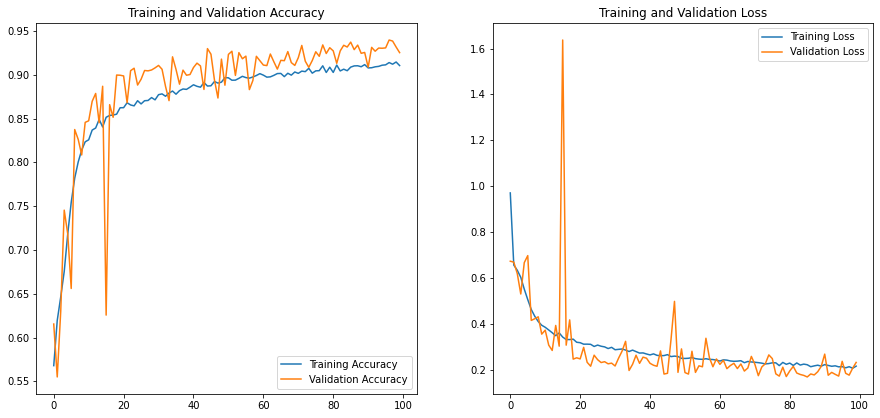

In [16]:
import matplotlib.pyplot as plt 
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()